<h3>Train Autoencoder on Strucutred Data</h3>
<p>Train the autoencoder on the structured data and use the reconstruction error for each sample as an anomaly score.</p>
<p>Samples with higher reconstruction errors may represent more severe health conditions</p>

Epoch 1/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 816us/step - loss: 0.8312 - val_loss: 0.6856
Epoch 2/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - loss: 0.6978 - val_loss: 0.6788
Epoch 3/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 747us/step - loss: 0.6894 - val_loss: 0.6766
Epoch 4/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - loss: 0.6875 - val_loss: 0.6756
Epoch 5/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 673us/step - loss: 0.6805 - val_loss: 0.6746
Epoch 6/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 637us/step - loss: 0.6906 - val_loss: 0.6728
Epoch 7/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - loss: 0.6857 - val_loss: 0.6715
Epoch 8/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step - loss: 0.6862 - val_loss: 0.6714
Epoch 9/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - loss: 0.6886 - val_loss: 0.6709
Epoch 10/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 672us/step - loss: 0.6867 - val_loss: 0.6701
Epoch 11/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 2s 711us/step - loss: 0.6913 - val_loss: 0.6707
Epoch 12

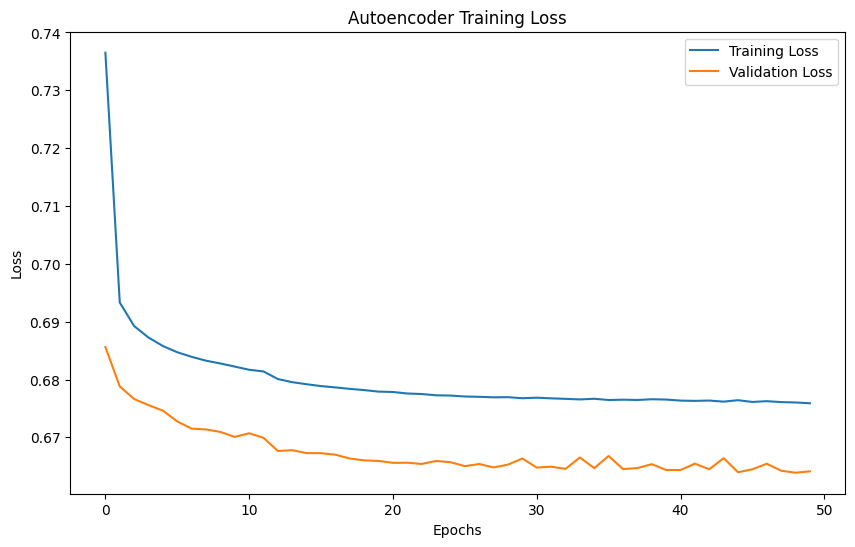

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt


#Load preprocessed structured data
structured_data = pd.read_csv('structured_data_preprocessed.csv')

#Separate features and target (unspervised learning)
X_structured = structured_data.values

#Standardise the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_structured)

#Train-test split  
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

#Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 16


#Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)    

#Decoder
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

#Autoencoder Model
autoencoder = models.Model(inputs = input_layer,outputs = decoded)

#Compile the Model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
 
#Train the Autoencoder
history = autoencoder.fit(X_train, X_train, 
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_val, X_val))


#Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [2]:
# Save the model
autoencoder.save('autoencoder.h5')

<h3>Compute Reconstruction Error</h3>
<p>After trainig the autoencoder, we will compute the reconstruction error for each patient</p>
<p>The reconstruction error serves as an <strong>anomaly score</strong>. We can interpret higher reconstruction errors as higher severity levels.</p>

3652/3652 ━━━━━━━━━━━━━━━━━━━━ 2s 454us/step


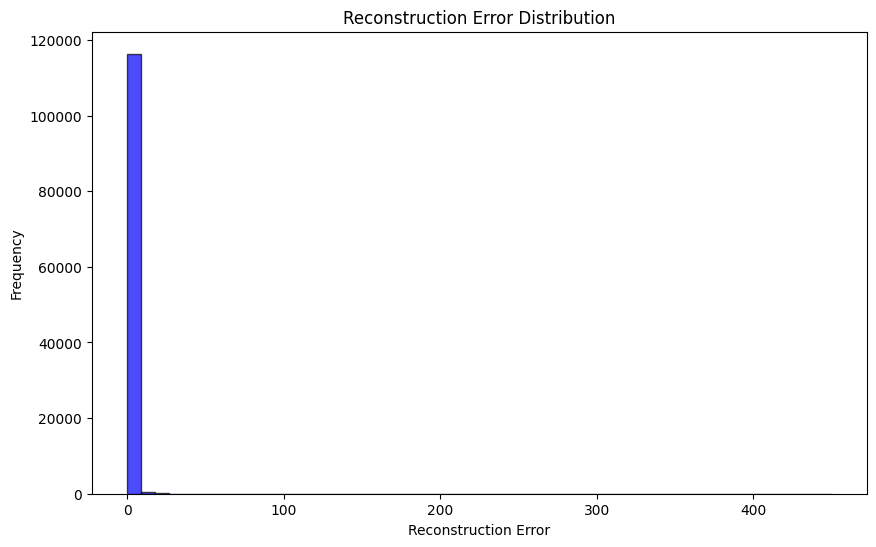

In [3]:
# Compute reconstruction error for the entire dataset   
reconstructed = autoencoder.predict(X_scaled)
reconstructed_error = np.mean(np.square(X_scaled - reconstructed), axis=1)

#Add reconstruction error to the structured data
structured_data['Reconstruction Error'] = reconstructed_error

#Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstructed_error, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


<h3>Latent Representaions</h3>
<p>Extract the latent features from the encoder part of the autoencoder for further analysis</p>

In [4]:
#Create encoder model
encoder = models.Model(inputs = autoencoder.input, outputs = encoded)

#Obtain latent representation
latent_features = encoder.predict(X_scaled)

#Create a DataFrame for latent features
latent_features_df = pd.DataFrame(data=latent_features, columns=[f'latent_{i}' for i in range(encoding_dim)])

#Add reconsturction error to the latent features DF
latent_features_df['reconstruction_error'] = reconstructed_error

#Save the latent features
latent_features_df.to_csv('latent_features.csv', index=False)

3652/3652 ━━━━━━━━━━━━━━━━━━━━ 2s 403us/step


<h3>Apply Clustering Algorithm</h3>
<p>We apply a clustering algorithm on the combined latent features to idnentify groups of patients that may correspond to different levels of health severity.</p>
<p>We use K-Means clustering to group patients based on their latent features</p>
<p>The silhouette score helps determine the optimal number of clusters</p>

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the silhouette score
range_n_clusters = list(range(2, 10))
best_n_clusters = 0
best_score = -1

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_features_df)
    silhouette_avg = silhouette_score(latent_features_df, cluster_labels)
    print(f'For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}')
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print(f'Best number of clusters: {best_n_clusters}')

# Apply KMeans with the best number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features_df)

# Add cluster labels to the DataFrame
latent_features_df['cluster'] = cluster_labels

For n_clusters = 2, the average silhouette_score is : 0.28395271925213306
For n_clusters = 3, the average silhouette_score is : 0.15246124628568605
For n_clusters = 4, the average silhouette_score is : 0.1401647492748553
For n_clusters = 5, the average silhouette_score is : 0.12414332808401068
For n_clusters = 6, the average silhouette_score is : 0.12346723180696524
For n_clusters = 7, the average silhouette_score is : 0.09718493769634776
For n_clusters = 8, the average silhouette_score is : 0.13678453405745214
For n_clusters = 9, the average silhouette_score is : 0.14092999676546367
Best number of clusters: 2


<h3>Assign Health Severity Index</h3>
<p>We assing a severit index based on the cluster assignments.</p>
<p>Clusters represent different groups of patients with varying health conditions</p>
<p>By assinging severity scores based on cluster labels, we derive a health severiy index without human bias</p>

In [6]:
# Map clusters to severity scores
# Assuming higher cluster labels correspond to higher severity
# If not, you may need to analyze clusters to order them appropriately

# Map cluster labels to severity scores (e.g., 0 to N-1)
cluster_severity = {cluster: index for index, cluster in enumerate(sorted(latent_features_df['cluster'].unique()))}
latent_features_df['severity_index'] = latent_features_df['cluster'].map(cluster_severity)

# Optionally, scale severity index to 0-10 range
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 10))
latent_features_df['severity_index_scaled'] = scaler.fit_transform(latent_features_df[['severity_index']])

<h3>Analyse and Validate Clusters</h3>
<p>It's important to analyse the clusters to ensure they make clinical sense.</p>
<p>By exmamining the characteristics of each cluster, you can interpret the severity levles.</p>
<p>*look for patterns in the data that correlate with the clusters*</p>

              AGE  DECEASED  HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE  \
cluster                                                                 
0        0.360876  0.070269             0.032947             0.036330   
1        0.532645  0.334046             0.050531             0.105665   

           INCOME  num_conditions  num_medications  num_procedures  \
cluster                                                              
0        0.106906        0.055987         0.008465        0.064203   
1        0.145613        0.100233         0.034806        0.147780   

         num_allergies  num_imaging_studies  ...  RACE_black  RACE_hawaiian  \
cluster                                      ...                              
0             0.054397             0.000189  ...    0.004553       0.000000   
1             0.073384             0.008465  ...    0.285457       0.041286   

         RACE_native  RACE_other  RACE_white  ETHNICITY_hispanic  \
cluster                                  

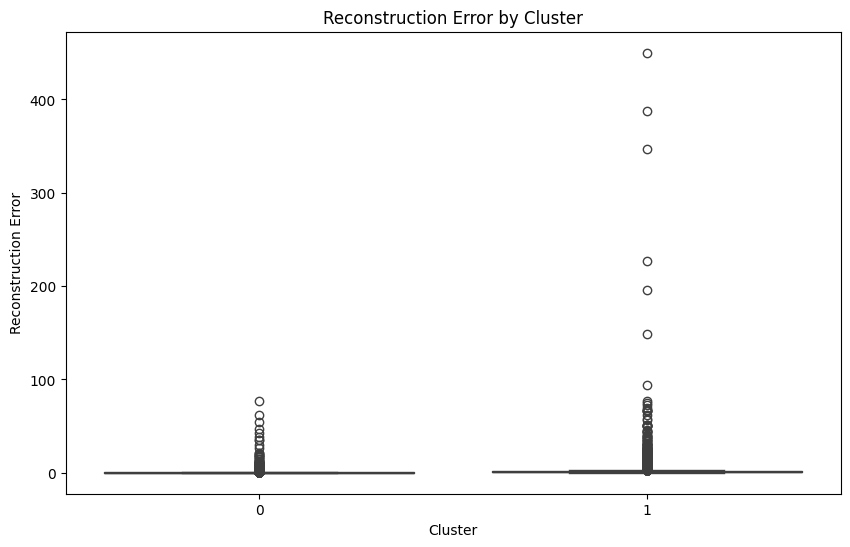

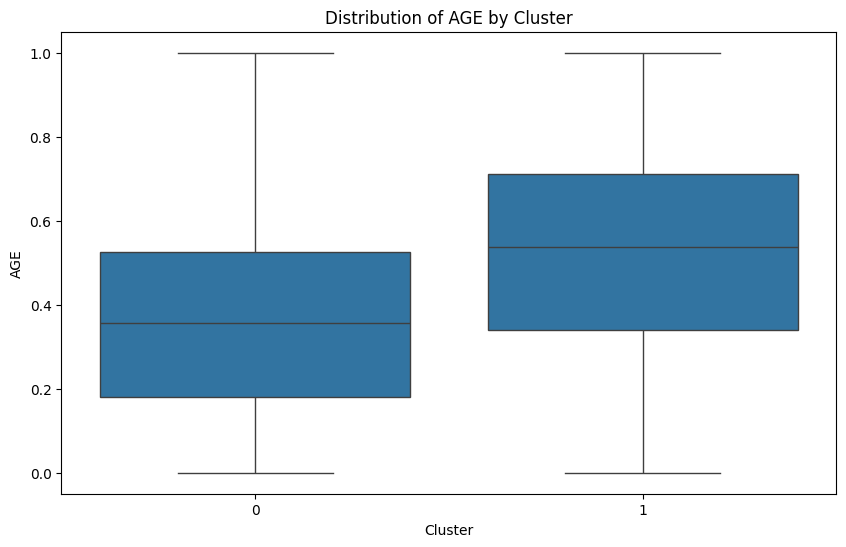

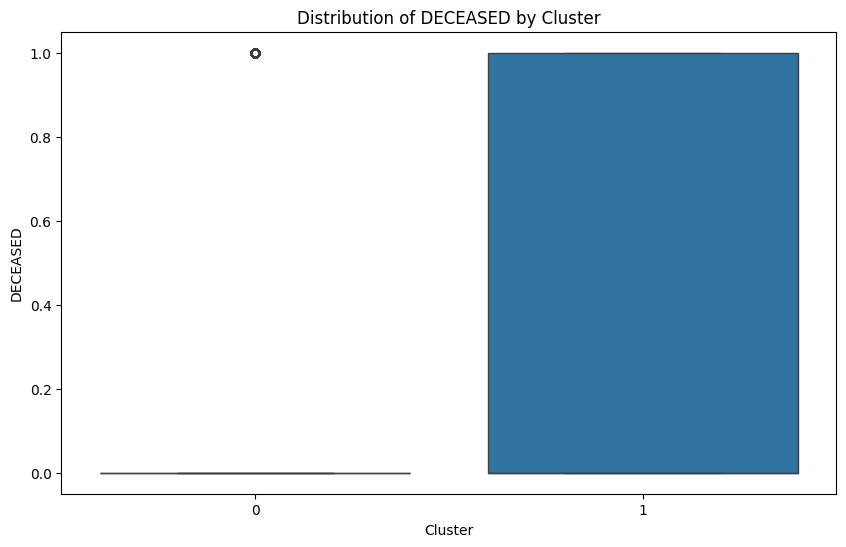

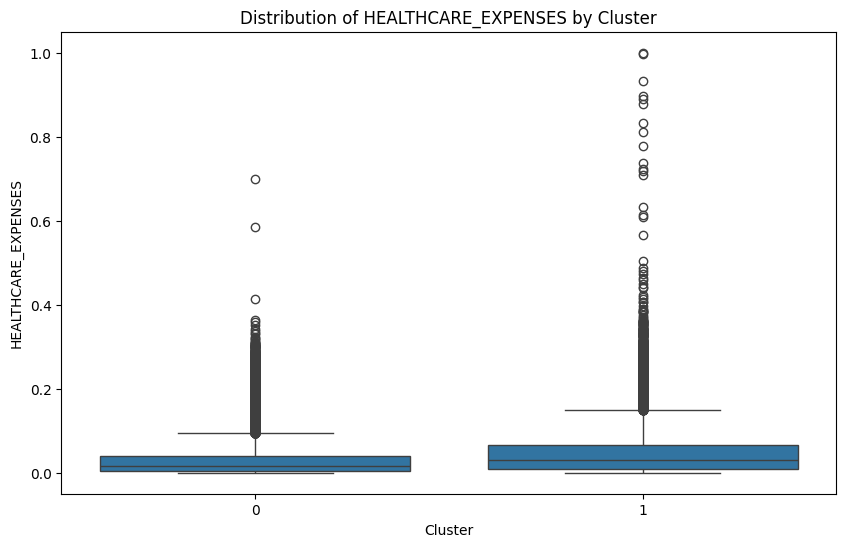

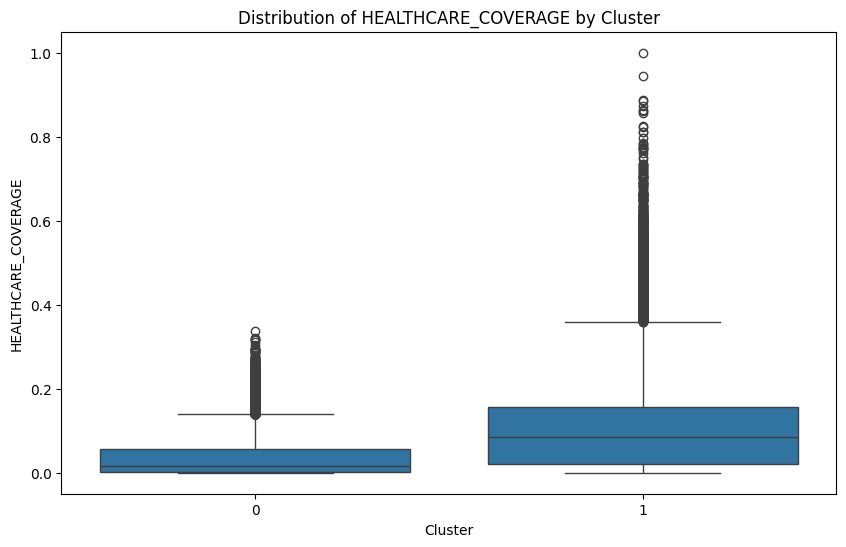

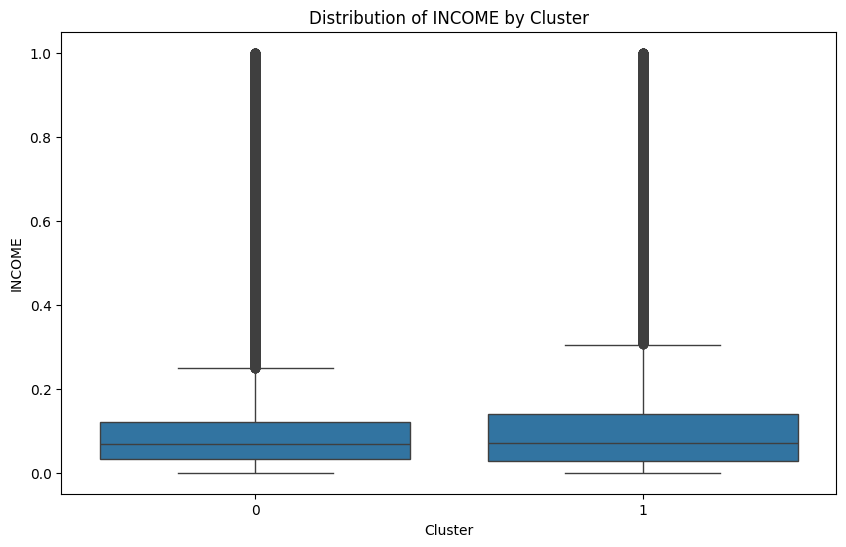

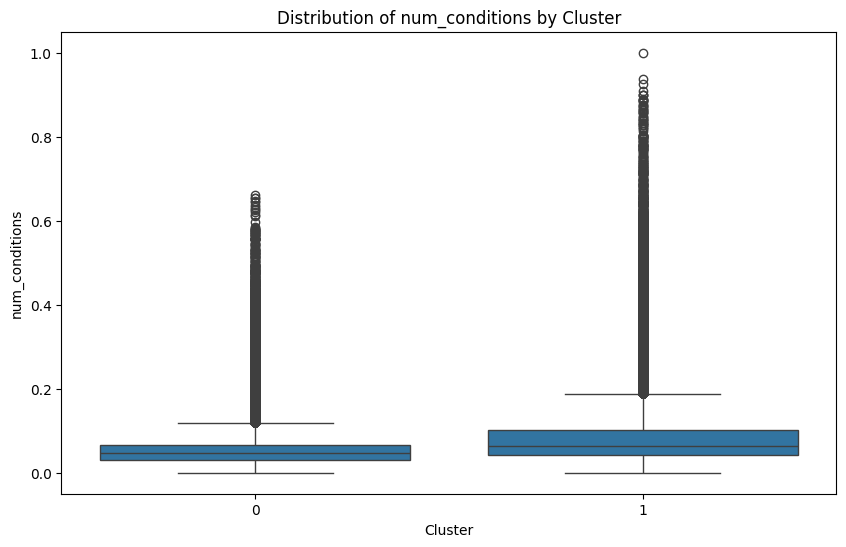

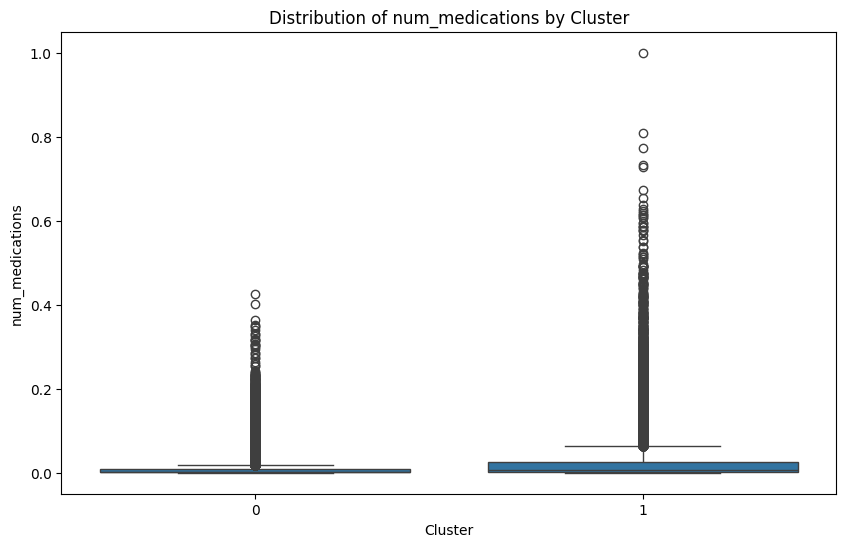

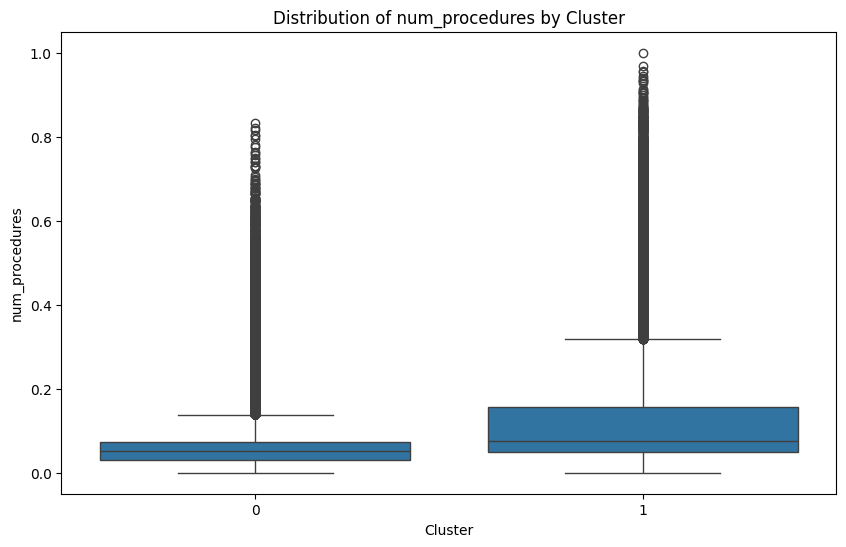

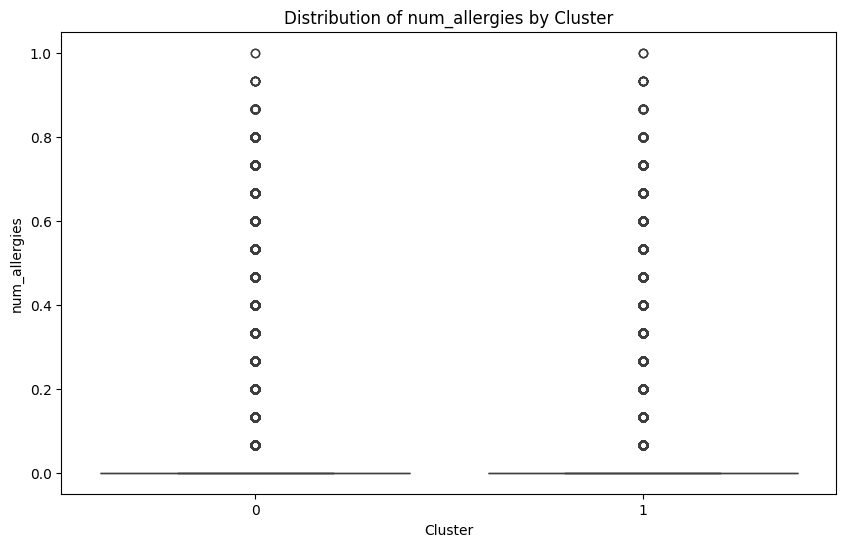

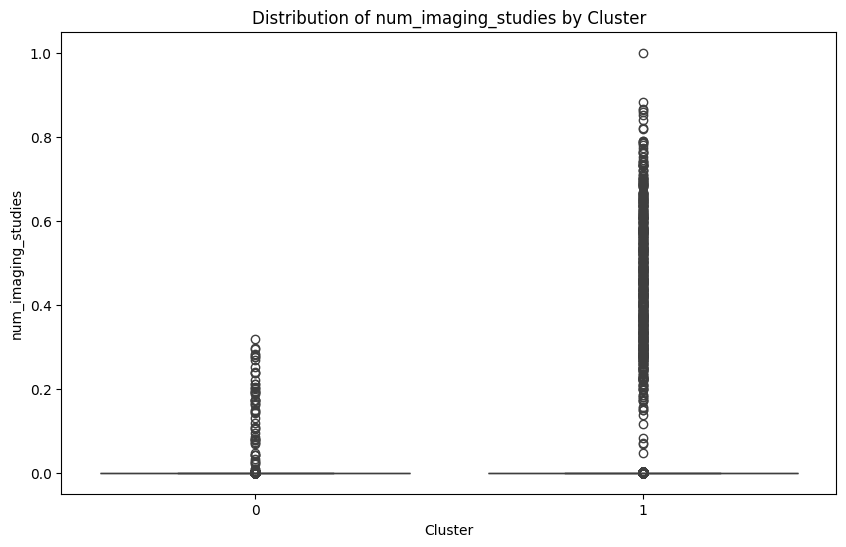

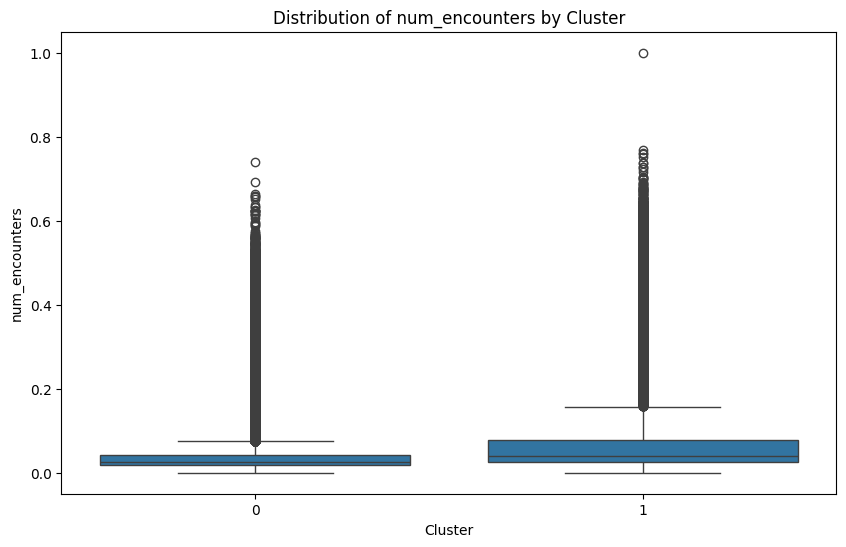

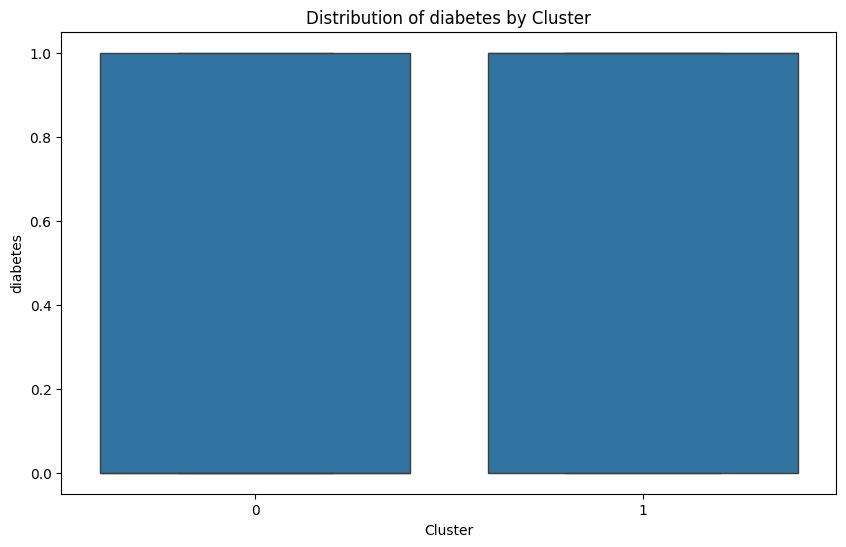

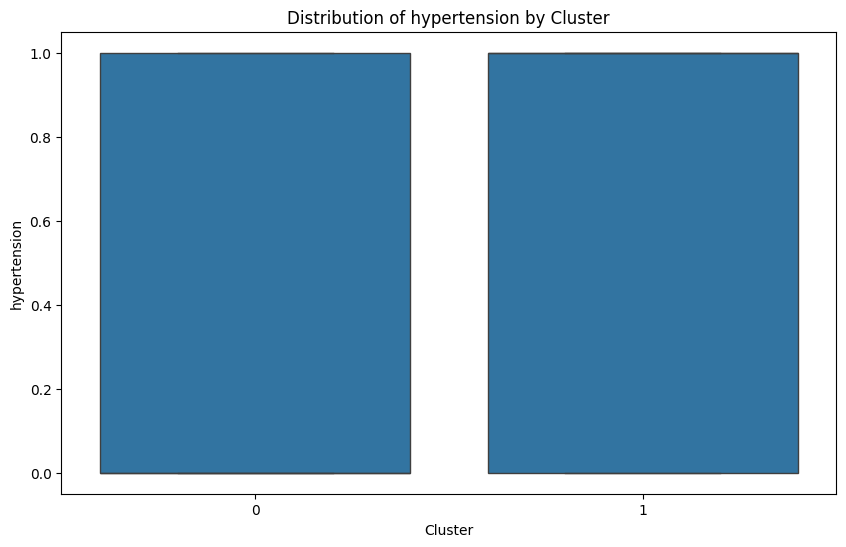

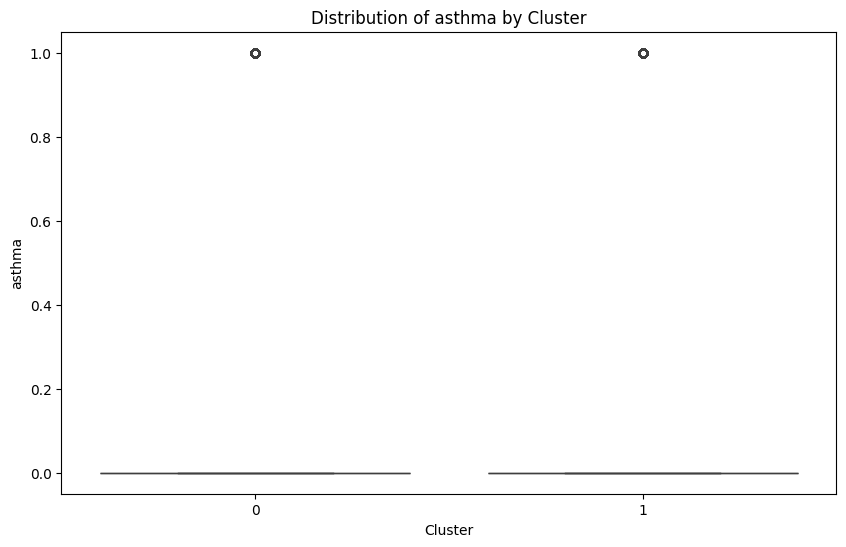

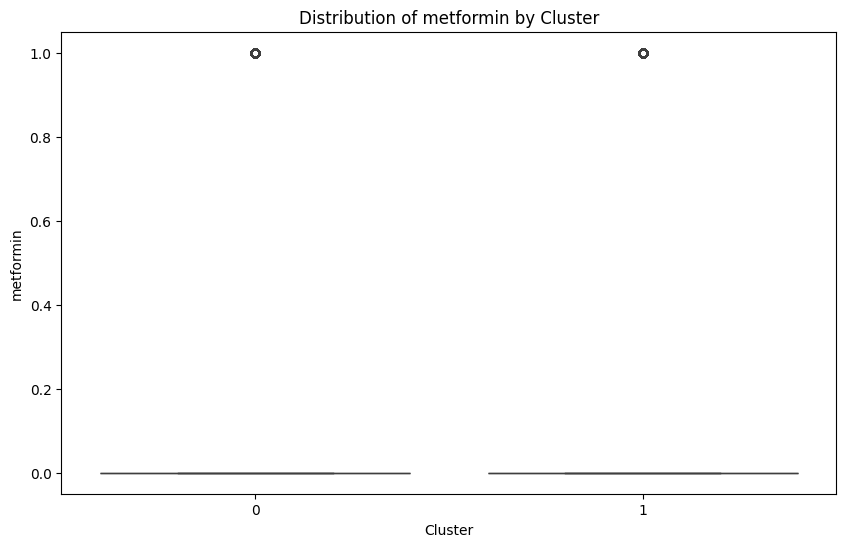

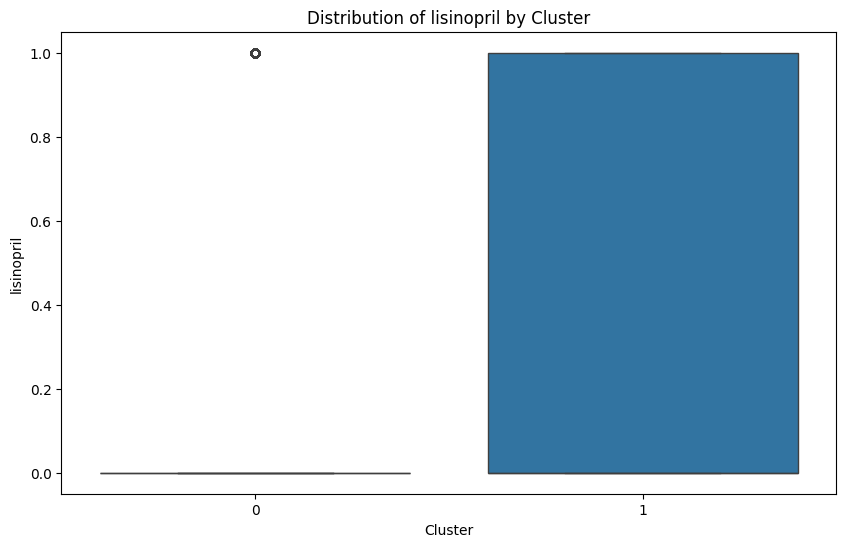

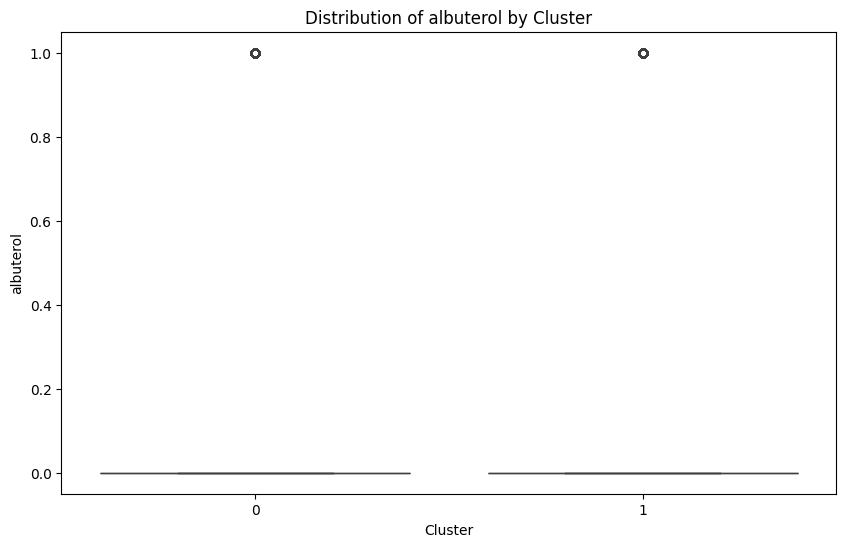

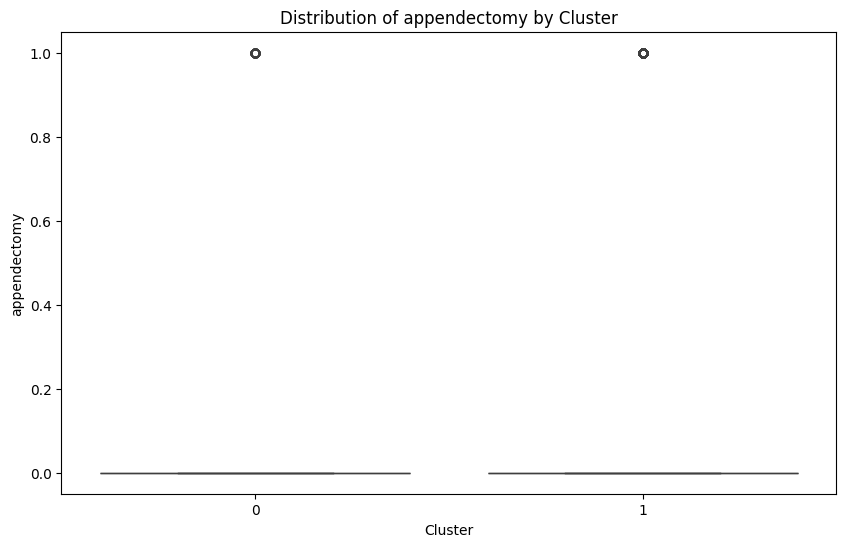

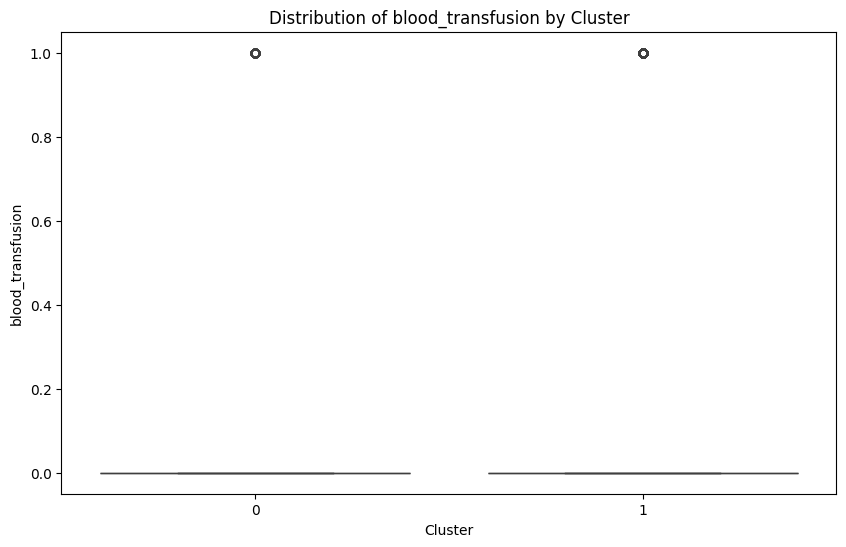

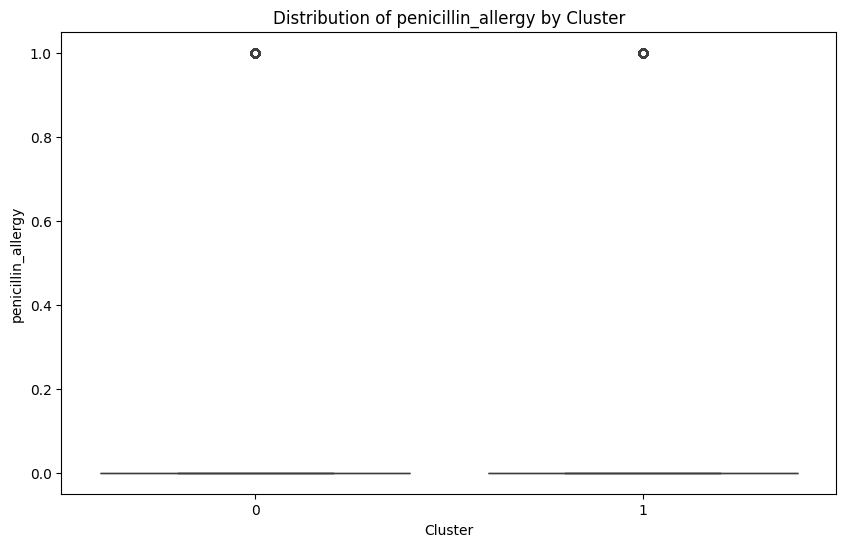

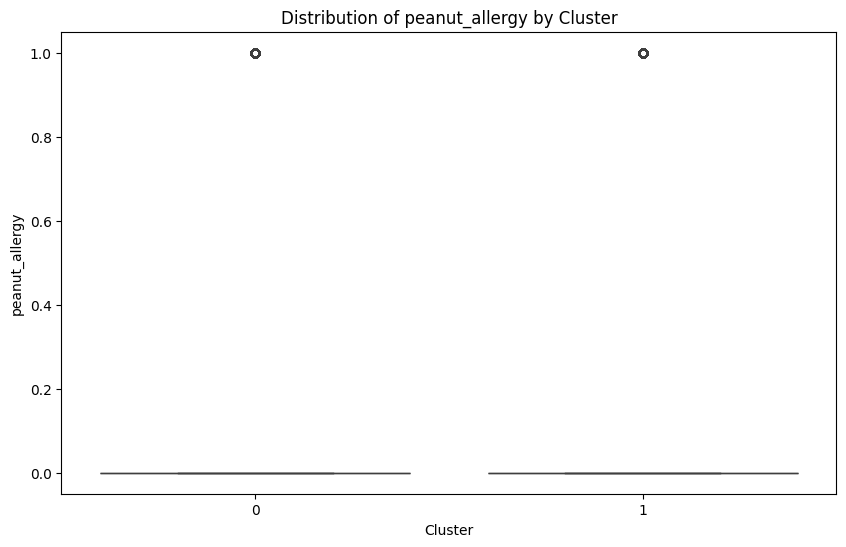

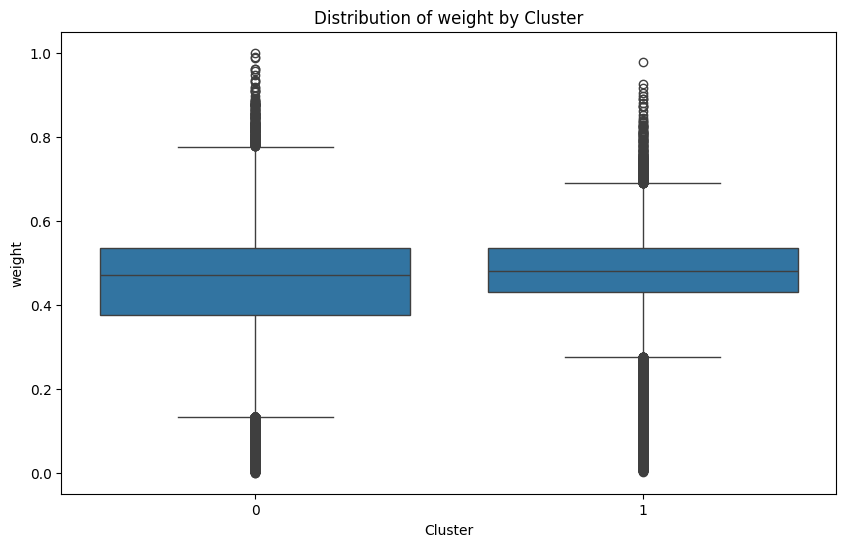

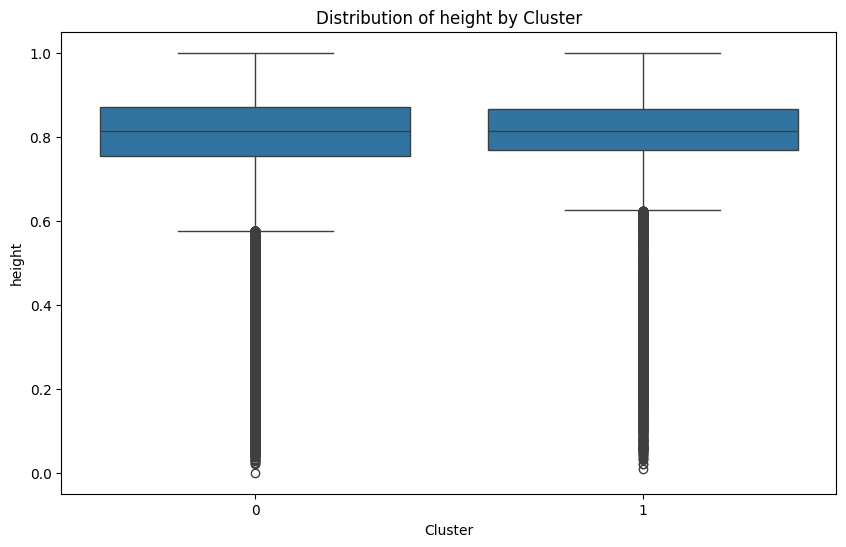

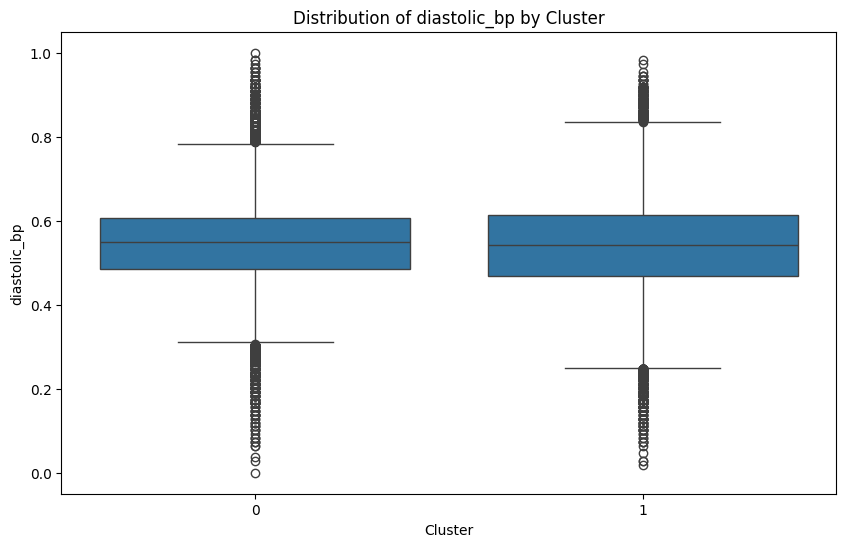

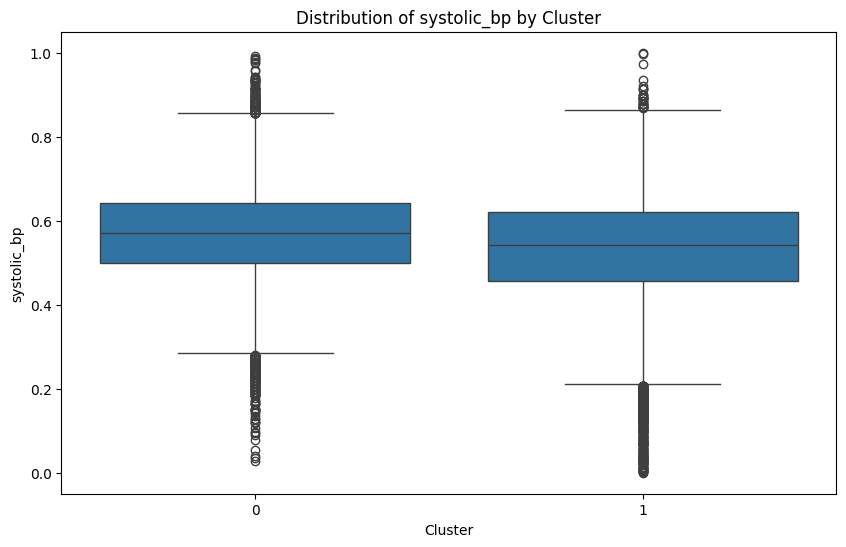

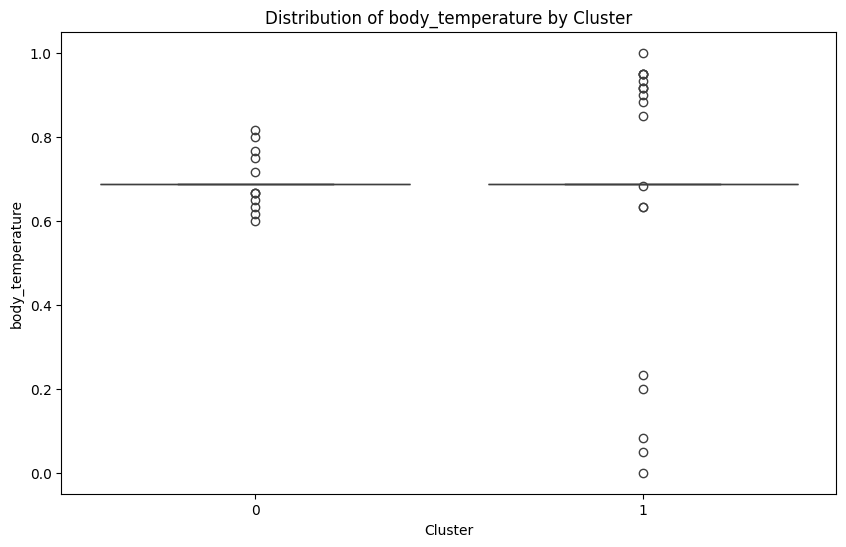

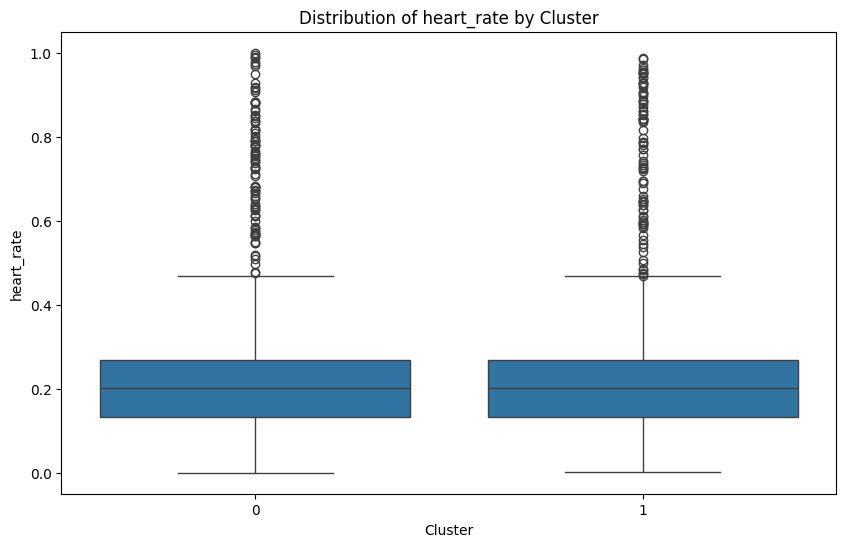

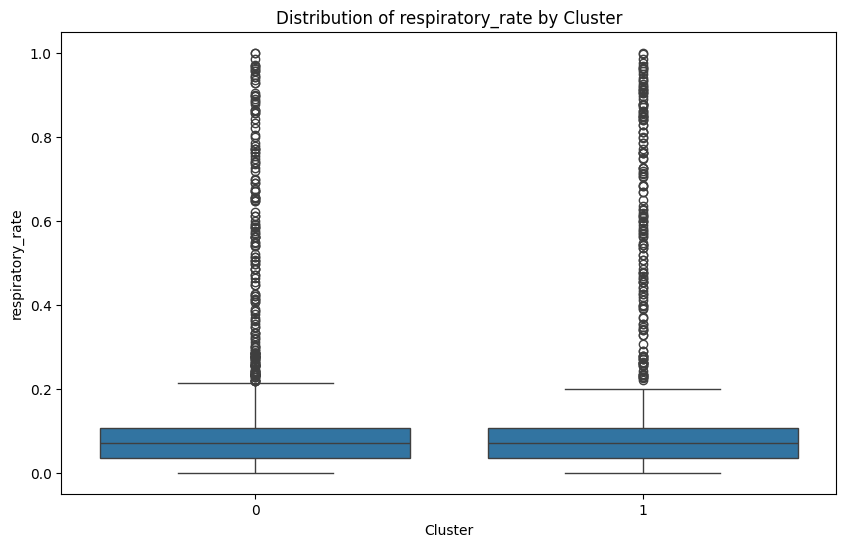

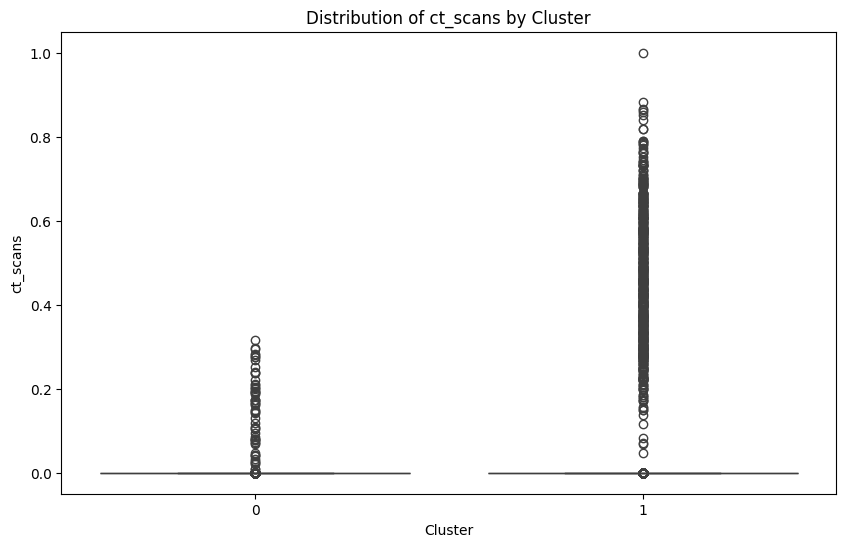

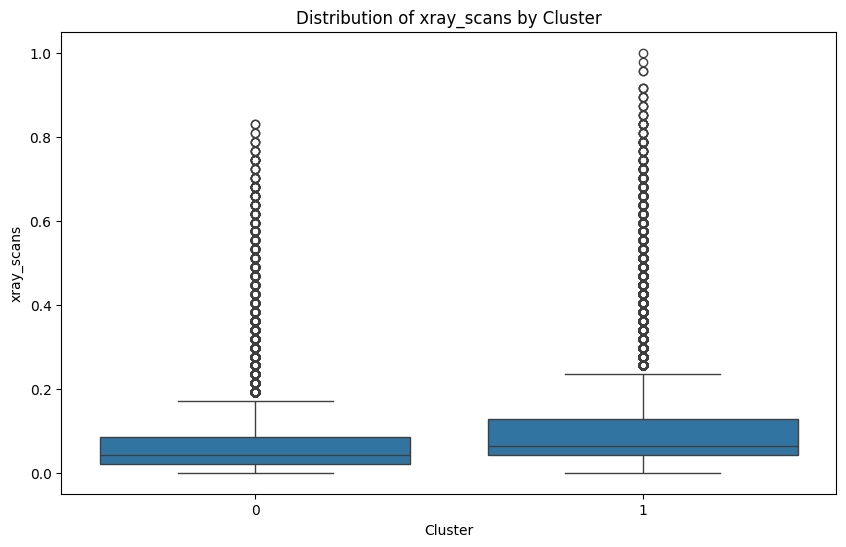

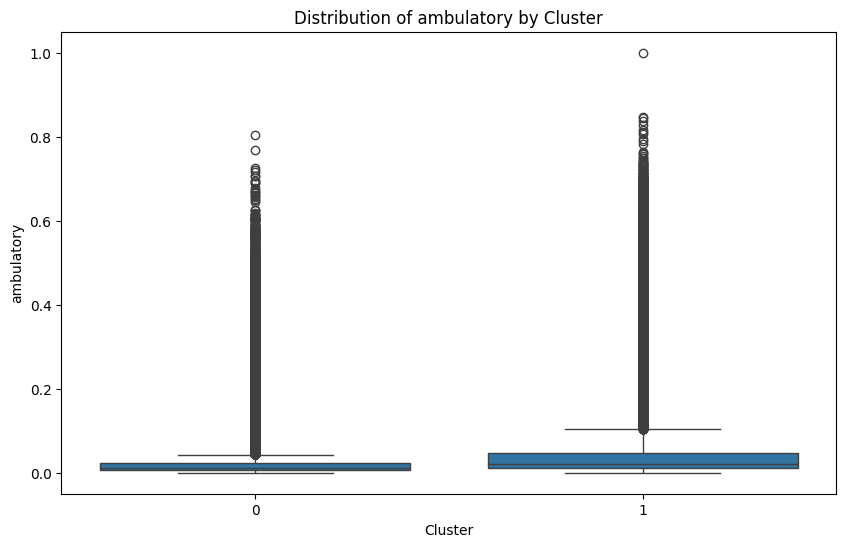

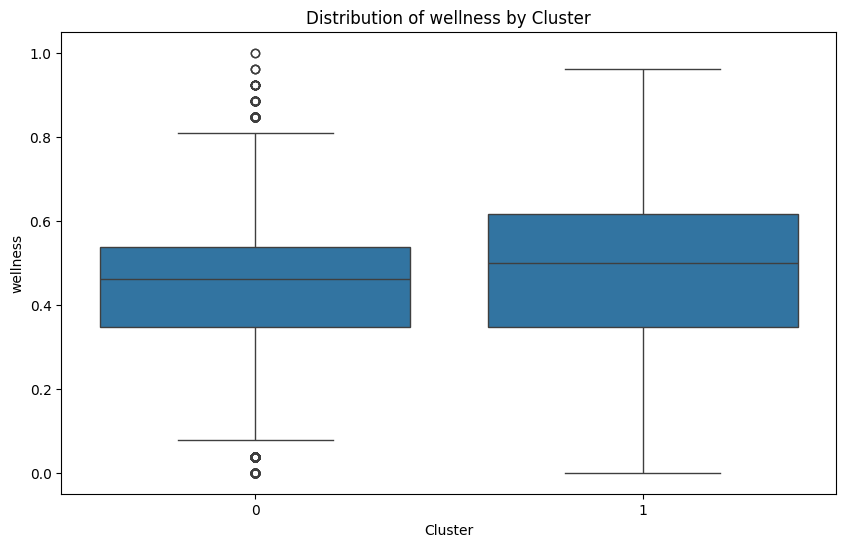

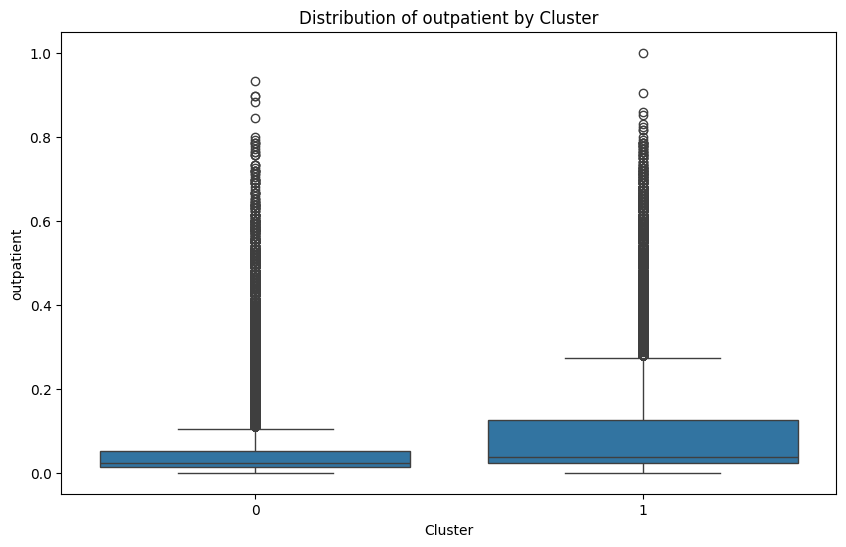

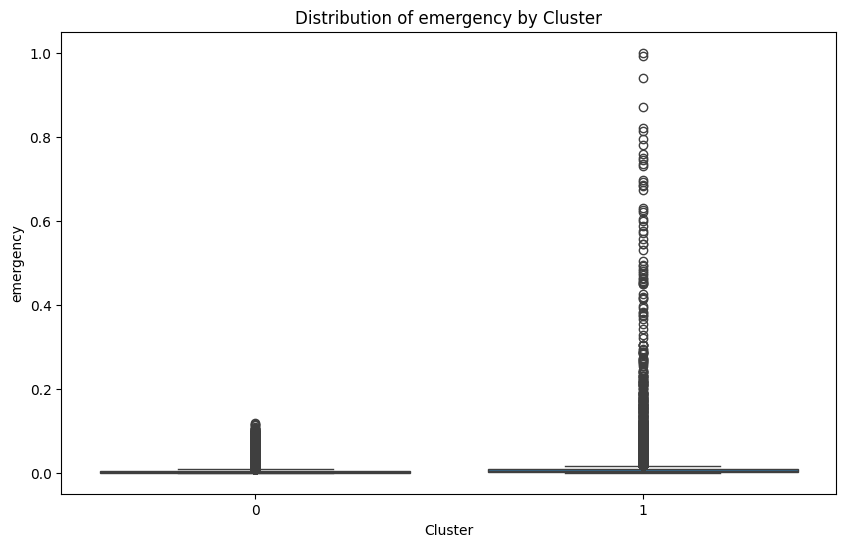

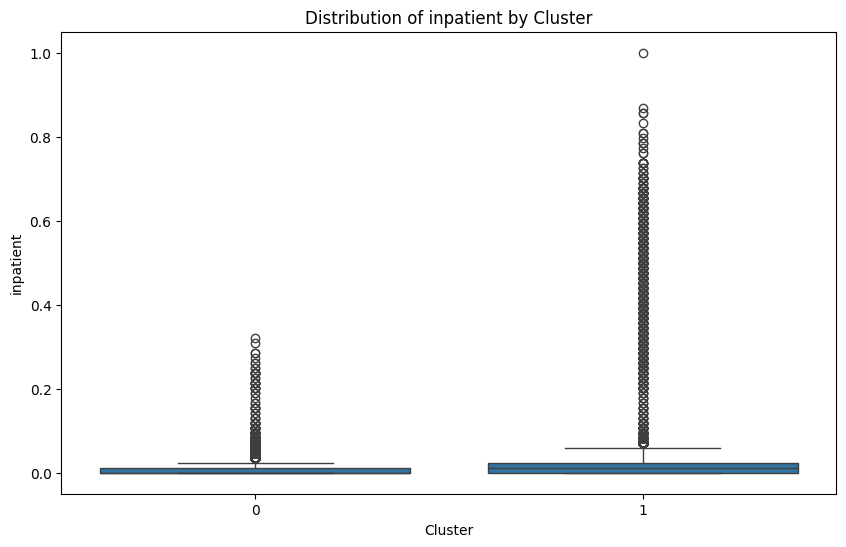

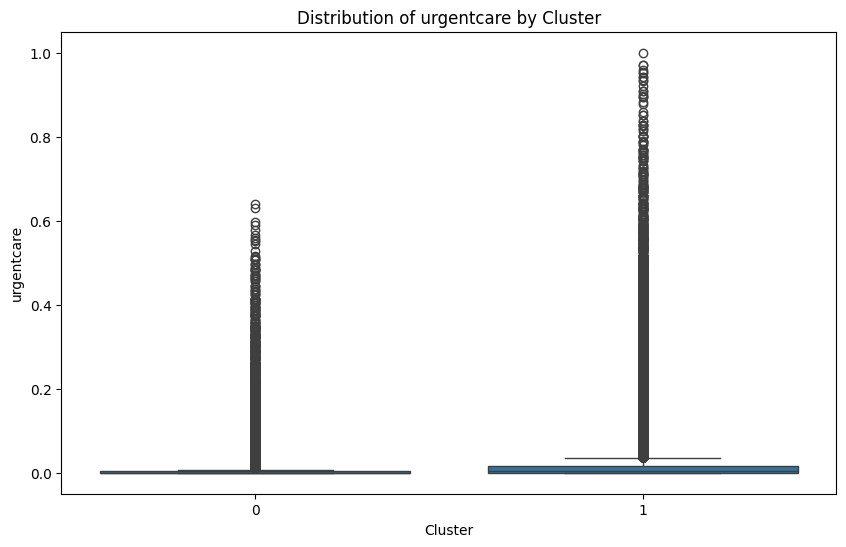

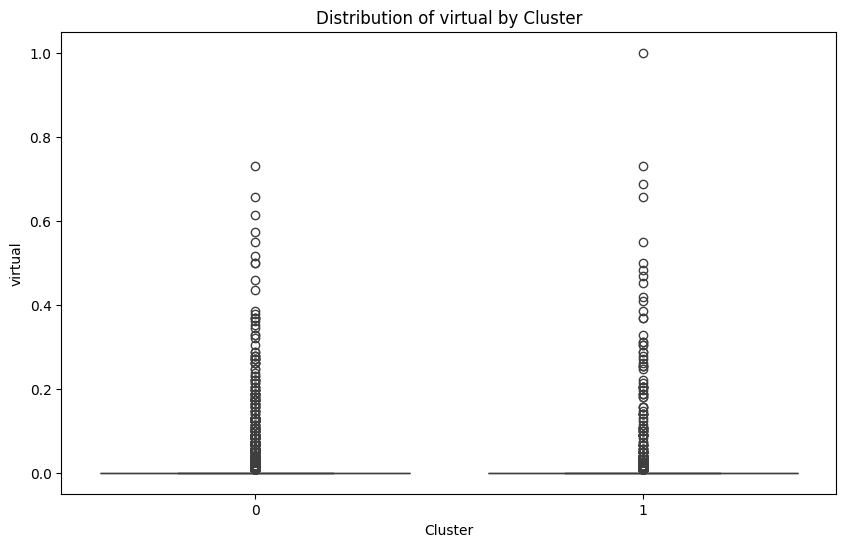

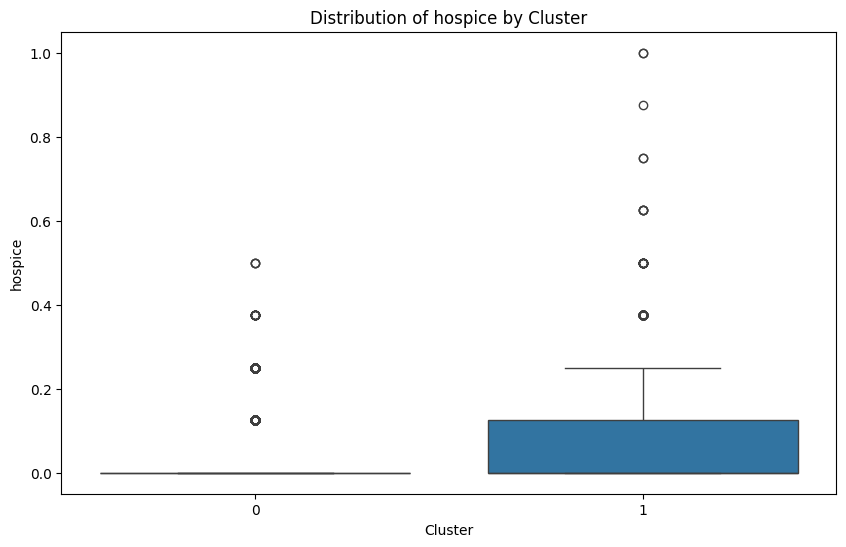

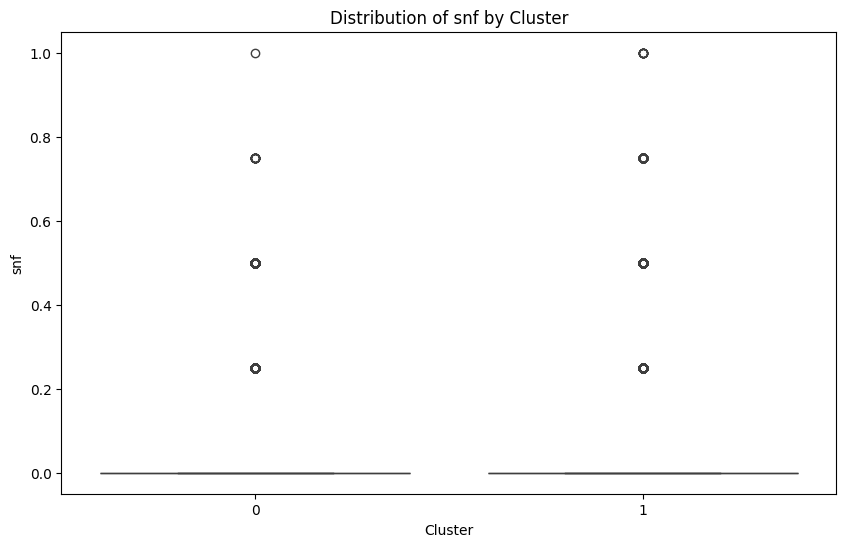

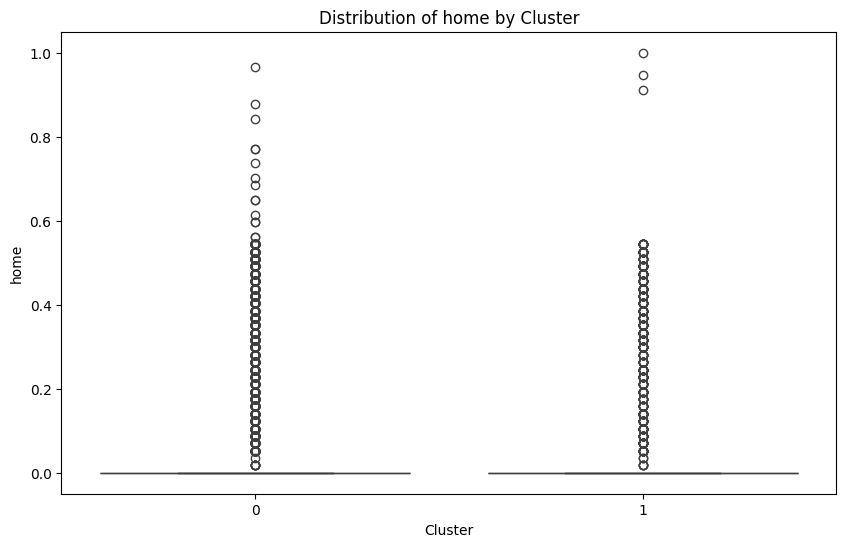

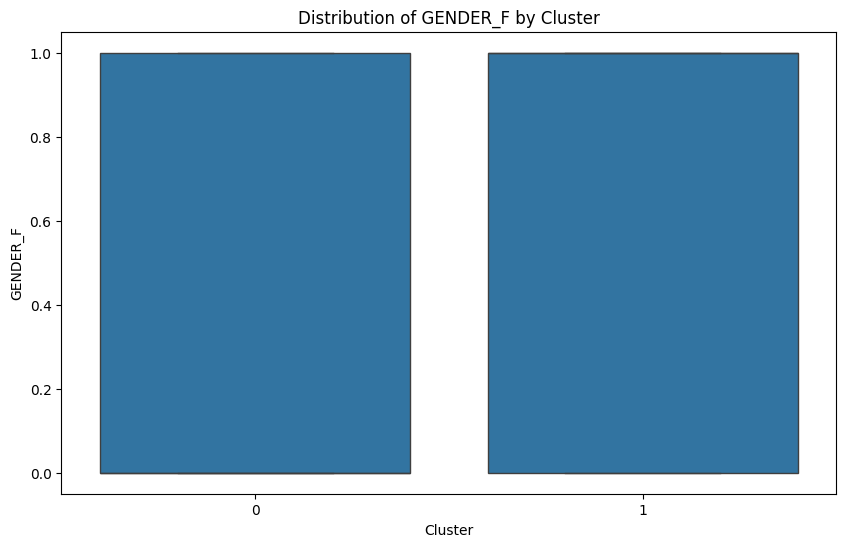

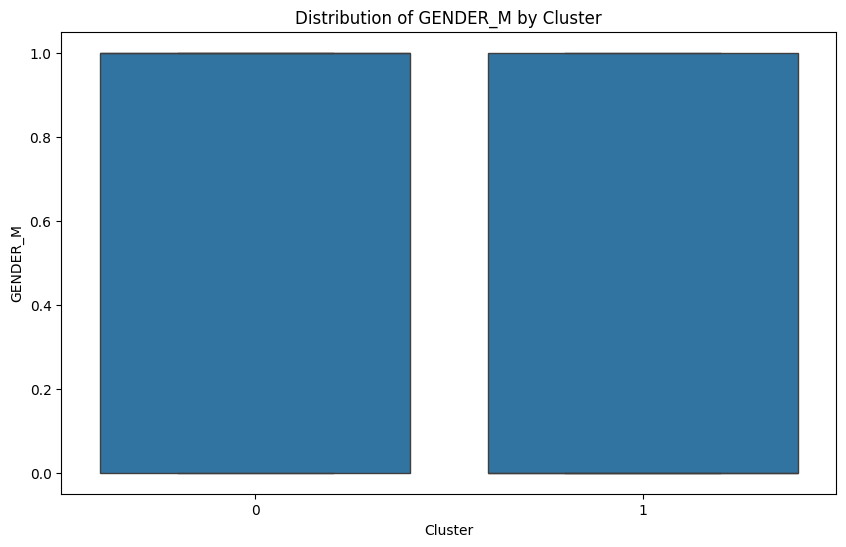

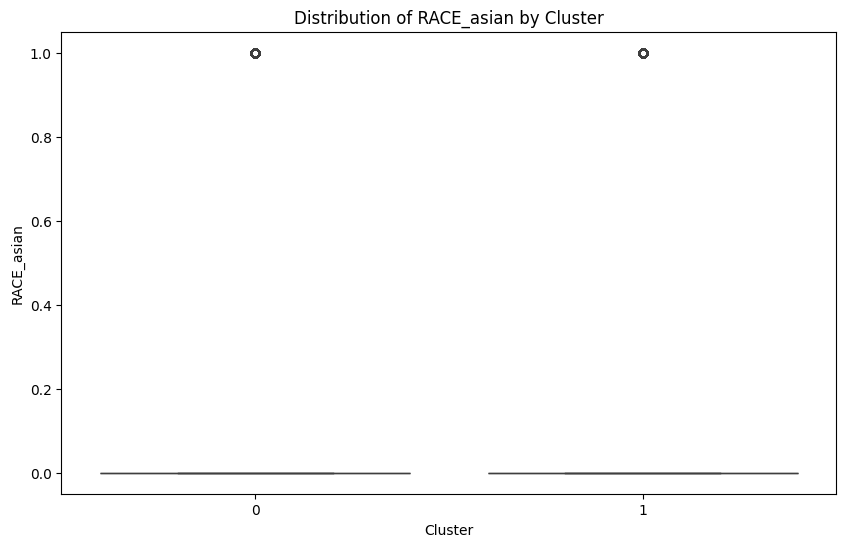

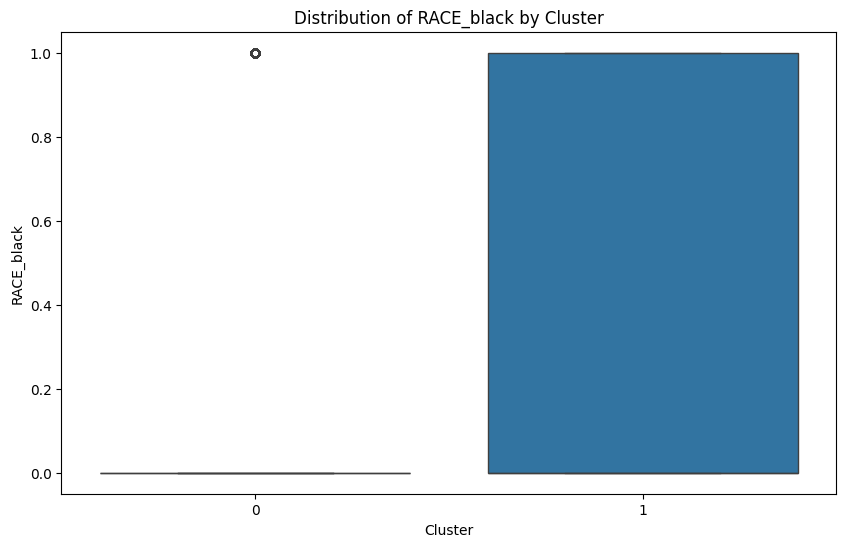

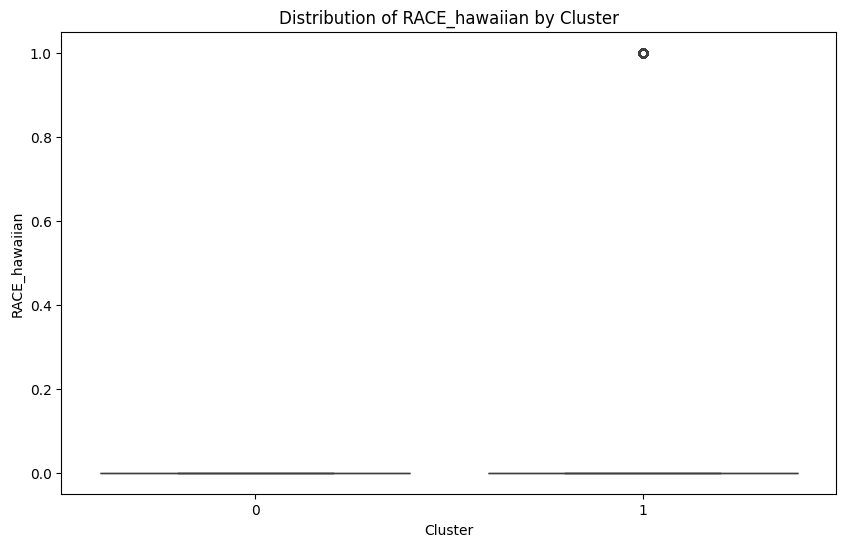

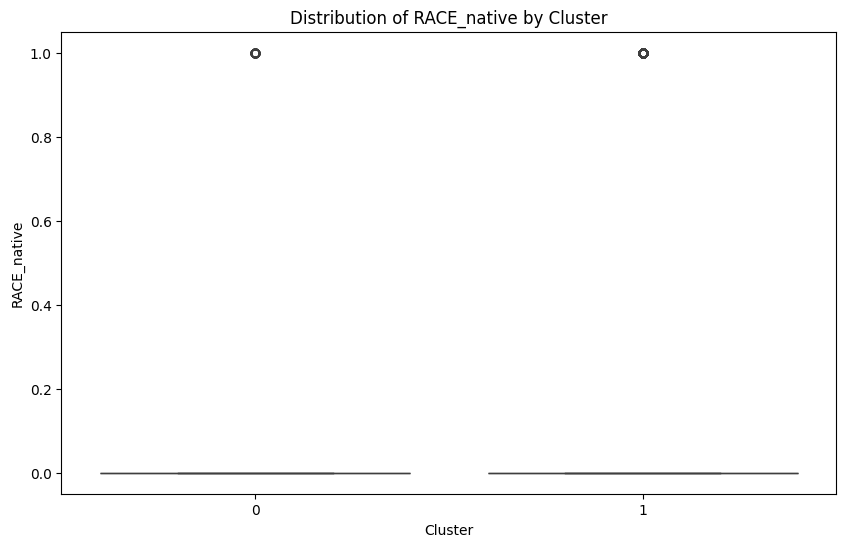

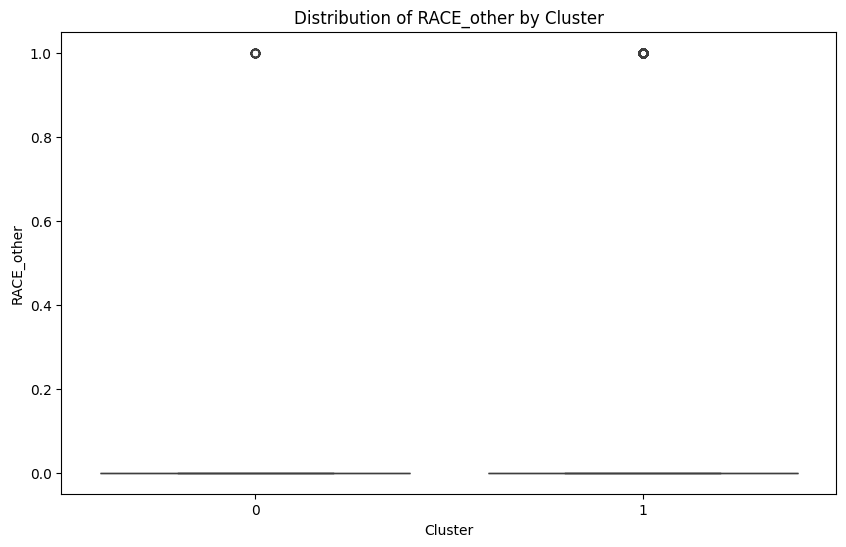

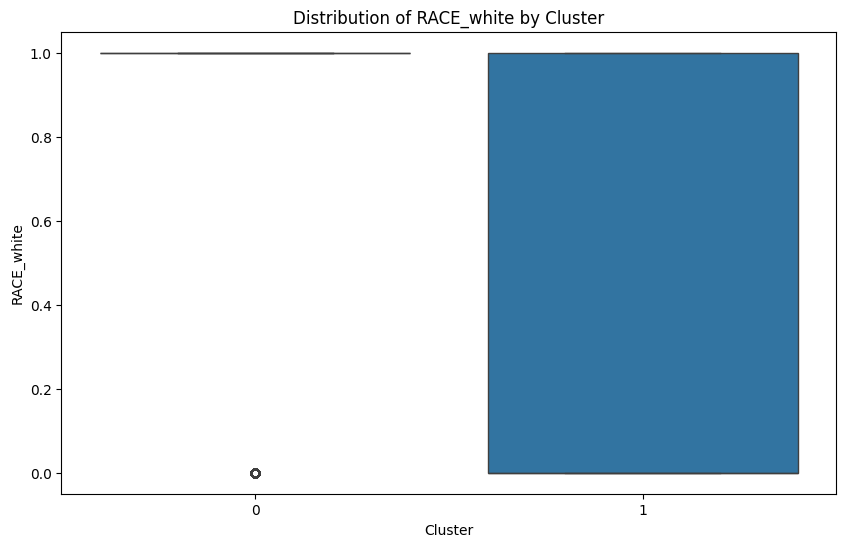

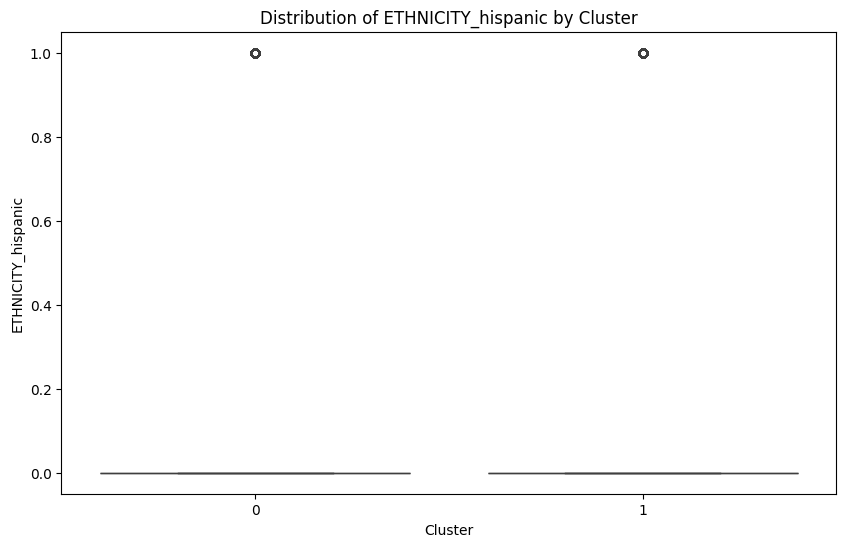

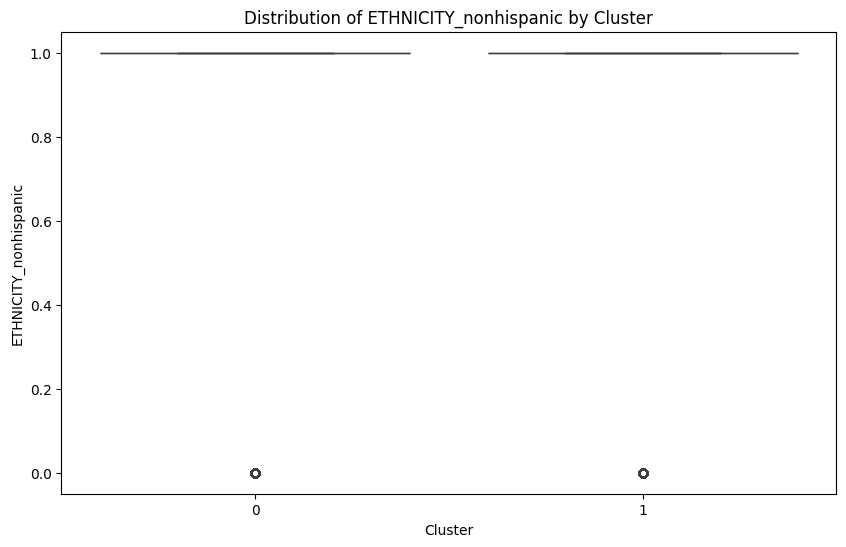

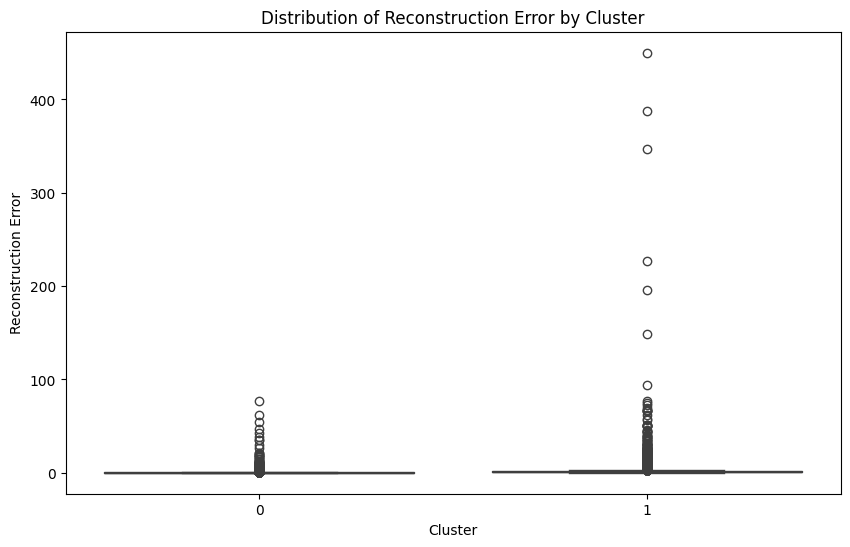

: 

In [7]:
# Combine original data with cluster labels
analysis_df = structured_data.copy()
analysis_df['cluster'] = latent_features_df['cluster']
analysis_df['severity_index'] = latent_features_df['severity_index_scaled']
analysis_df['reconstruction_error'] = structured_data['Reconstruction Error']  # Add this line

# Group by cluster and compute summary statistics
cluster_summary = analysis_df.groupby('cluster').mean()
print(cluster_summary)

# Visualize reconstruction error by cluster
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='reconstruction_error', data=analysis_df)
plt.title('Reconstruction Error by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Reconstruction Error')
plt.show()

# Visualize key features by cluster
key_features = structured_data.columns.tolist()  # List of feature names

for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=analysis_df)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


<p>Need restart kernel? Dw I've got you</p>

In [ ]:
# import os
# import IPython

# # Restart the kernel
# os._exit(00)